In [15]:
!pip install faiss-cpu --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 4.3 MB/s 


In [16]:
import pickle
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances


# **Welcome to week 3 project!**

Congratulations on making it to week 3! 👏 In the first week of this course, we covered the basics of how to design personalized recommendation systems. We then provided some system design examples for large scale recommenders from corporations like Spotify and YouTube, as well as techniques for candidate generation, specifically the two-tower model being used at Twitter and Pinterest.

Last week, we covered details of ML approaches for recommendations: including multi-task recommenders and contextual bandits.

In week 3, we covered various techniques for learning user representations.

In this week's project, we will touch upon two key aspects related to representations:
1. How do we query large amount of vectors in efficient time.
2. How can we infer various user representations and see what their impact is on downstream task.

Lets begin with Part A, which tells us how we could handle a large number of candidate items or user representations in an efficient manner. 


# Part A: Approximate nearest neighbor search

Often we are interested in finding nearest neighbors in a large space of vectors. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. Annoy, Faiss, ScaNN are typical libraries that are used for efficient vector similarity search at scale. They implement algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

In the first part of this week's project, we will simulate embeddings of 1 million items and try to find k-nearest neighbours for an item of interest. We will implement a vanilla search function to fetch the top-k nearest neighbors and estimate the time it takes for us to do so. We will then compare this with FAISS -- Facebook's nearest neighbour search library, and compare the time it takes for us to get nearest neighbours from FAISS versus our own implementation.

Lets first generate a simulated dataset of embeddings of 1 million items.

In [17]:
d = 64                           # dimension
nb = 1000000                     # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

Now that we have these items, lets take up the goal of finding the top-5 items closest to this specific item. Your goal is to implement your function to estimate the top-5 items and print the average distance of these top 5 items to the query item.

In [18]:
k=4
query_vector = xb[2:3]

In [19]:
cosine_distances(query_vector, xb[:10])

array([[2.3970294e-01, 1.8975610e-01, 1.1920929e-07, 2.7235287e-01,
        1.9721597e-01, 2.4972141e-01, 2.3136586e-01, 2.5156391e-01,
        2.3270959e-01, 2.3770028e-01]], dtype=float32)

In [20]:
np.argsort(cosine_distances(query_vector, xb[:10]))

array([[2, 1, 4, 6, 8, 9, 0, 5, 7, 3]])

In [21]:
def find_top_k_nn(distfn, query_vector,k):
    """
    in this function, implement your definition of top-k nearest neighbours, and return the distances
    and indices of the these top-k items.
    """
    # the lower the distance the higher the similarity
    distances = distfn(query_vector, xb)
    inds = np.argsort(distances)

    return distances[0][inds[:k]][0], inds[:k][0]

With your top-k NN function implemented, call this function to get the top-k nearest neighbor items for the query_vector and print the average distance. Also, print the time it takes to run this function:

In [22]:
%%time
D, I = find_top_k_nn(cosine_distances, query_vector, k)
print("distances from the k nearest neighbor fetched:",D)
print("indices from the k nearest neighbor fetched:",I)
print("average distance of the k- nearest neighbors fetched: ",D.mean())

distances from the k nearest neighbor fetched: [1.1920929e-07 9.1334343e-02 9.2645407e-02 ... 4.1436869e-01 4.1700172e-01
 4.2110068e-01]
indices from the k nearest neighbor fetched: [     2 379284 539651 ... 112016 688988 687319]
average distance of the k- nearest neighbors fetched:  0.23822601
CPU times: user 456 ms, sys: 347 ms, total: 802 ms
Wall time: 423 ms


In [23]:
%%time
D, I = find_top_k_nn(euclidean_distances, query_vector, k)
print("distances from the k nearest neighbor fetched:",D)
print("indices from the k nearest neighbor fetched:",I)
print("average distance of the k- nearest neighbors fetched: ",D.mean())

distances from the k nearest neighbor fetched: [0.        2.054384  2.0941472 ... 4.2324553 4.2388873 4.2939873]
indices from the k nearest neighbor fetched: [     2 379284 539651 ... 492301   9185 246664]
average distance of the k- nearest neighbors fetched:  3.299404
CPU times: user 507 ms, sys: 816 ms, total: 1.32 s
Wall time: 391 ms


Now lets switch to using Faiss https://github.com/facebookresearch/faiss

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. 

### Similarity search in Faiss

Given a set of vectors x_i in dimension d, Faiss builds a data structure in RAM. After the structure is constructed, when given a new vector x in dimension d it performs efficiently the operation:

$i = argmin_i ||x - x_i||$

where ||.|| is the Euclidean distance (L2).

In Faiss terms, the data structure is an index, an object that has an add method to add x_i vectors. Note that the x_i's are assumed to be fixed. Computing the argmin is the search operation on the index.

### Indexes used by Faiss

1. The inverted file from “Video google: A text retrieval approach to object matching in videos.”, Sivic & Zisserman, ICCV 2003. This is the key to non-exhaustive search in large datasets. Otherwise all searches would need to scan all elements in the index, which is prohibitive even if the operation to apply for each element is fast


2. The product quantization (PQ) method from “Product quantization for nearest neighbor search”, Jégou & al., PAMI 2011. This can be seen as a lossy compression technique for high-dimensional vectors, that allows relatively accurate reconstructions and distance computations in the compressed domain.


3. The three-level quantization (IVFADC-R aka IndexIVFPQR) method from "Searching in one billion vectors: re-rank with source coding", Tavenard & al., ICASSP'11.

We will implement these three indexes from faiss and use each of these three to search the index, and get the top-k nearest neighbour vectors, and estimate the average distance.

Lets first construct the three indexes: index1, index2, index3 based on Flat index, Inverted index and product quantization techniques:

In [24]:
%%time
index1 = faiss.IndexFlatL2(d)   # build the index
index1.add(xb)                  # add vectors to the index
print("total number of vectors indexed = ",index1.ntotal)

total number of vectors indexed =  1000000
CPU times: user 105 ms, sys: 4.04 ms, total: 109 ms
Wall time: 105 ms


In [25]:
%%time
nlist = 100
quantizer = faiss.IndexFlatL2(d)  # the other index
index2 = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
index2.train(xb)
index2.add(xb)
print("total number of vectors indexed = ",index2.ntotal)

total number of vectors indexed =  1000000
CPU times: user 4.18 s, sys: 131 ms, total: 4.31 s
Wall time: 1.34 s


In [26]:
%%time
nlist = 100
m = 8
k = 4
quantizer = faiss.IndexFlatL2(d)  # this remains the same
index3 = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
index3.train(xb)
index3.add(xb)
print("total number of vectors indexed = ",index3.ntotal)

total number of vectors indexed =  1000000
CPU times: user 49.1 s, sys: 135 ms, total: 49.2 s
Wall time: 12.7 s


Now that we have these three indexes, let us query these to fetch the top-k nearest neghbour for our query_vector and compute the average distance we obtain for each.

We will also time these commands, to find out the trade-off between accuracy and latency.

In [27]:
%%time
D, I = index1.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[0.        4.2204943 4.3854527 4.6933837]]
indices from the k nearest neighbor fetched: [[     2 379284 539651 400245]]
average distance of the k- nearest neighbors fetched:  3.324833
CPU times: user 78.4 ms, sys: 1.98 ms, total: 80.4 ms
Wall time: 64.6 ms


In [28]:
%%time
D, I = index2.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[0.        5.0635023 5.4133463 5.642405 ]]
indices from the k nearest neighbor fetched: [[     2 859123 177280  74082]]
average distance of the k- nearest neighbors fetched:  4.0298133
CPU times: user 2.47 ms, sys: 16 µs, total: 2.49 ms
Wall time: 1.68 ms


In [29]:
%%time
D, I = index3.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[1.1111705 5.027693  5.1296997 5.1854224]]
indices from the k nearest neighbor fetched: [[     2 351653 703885 841943]]
average distance of the k- nearest neighbors fetched:  4.1134963
CPU times: user 841 µs, sys: 2 ms, total: 2.84 ms
Wall time: 2.24 ms


Running all these, we observe that the product quantization based index is an order of magnitude faster than the inverted index. In terms of accuracy, if we assume that the lower the distance the more accurate the result, FlatIndex gives us the least distance.

### Goal 1 for this week: Implement your k-NN function and time it

The main goal for this part of the project is to implement your vanilla nearest neighbor function and fetch the closest k nearest neighbours to the query vector. Important to note that your implementation will give an exact result, i.e., your implementation will find the exact closest k vectors that will give the minimum distance to the query_vector.

Please compile the results in a table, and compare the average distance obtained and the time it took to query the 1 million vectors. A nice 2D plot would also give you a good idea of the speed-accuracy trade-off involved.

In [30]:

data_map = {
    "Method": ["Exact Search (cosine)", "Exact Search (Euclidean)", "faiss Index-Flat", "faiss Index-Inverted", "faiss Index-QuantizedbInverted"],
    "Processing Time" : [809, 1033, 61.3,2.97,2.14],
    "Avg distances"   : [0.23822601,3.299404, 3.324833, 4.0298133, 4.1134963]
    
}
knn_results_df = pd.DataFrame(data_map)
knn_results_df

,Method,Processing Time,Avg distances
0,Exact Search (cosine),809.00,0.238226
1,Exact Search (Euclidean),1033.00,3.299404
2,faiss Index-Flat,61.30,3.324833
3,faiss Index-Inverted,2.97,4.029813
4,faiss Index-QuantizedbInverted,2.14,4.113496


**NOTE THAT COSINE DISTANCE IS NOT ON SAME SCALE AS OTHER DISTANCES (cosine v/s others use euclidean)


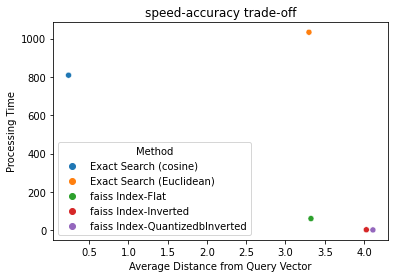

In [31]:
plt = sns.scatterplot(data=knn_results_df, x="Avg distances", y="Processing Time", hue="Method")

plt.set(xlabel ="Average Distance from Query Vector", ylabel = "Processing Time", title ='speed-accuracy trade-off')

print("**NOTE THAT COSINE DISTANCE IS NOT ON SAME SCALE AS OTHER DISTANCES (cosine v/s others use euclidean)")

# Part B: User representations

In the second part of this week's project, we wish to understand few ways of estimating user representations, and how it impacts the performance of downstream tasks.

To this end, we will work on top of our H&M dataset, and develop a few different ways of representing users.

The broader framework here will be -- we fix the article representations, and fix the downstream task, and then vary the user representations and see how the performance of the downstream task changes based on different user representation techniques.


In [3]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import datetime
import itertools
import os
from contextlib import redirect_stdout
from tqdm.notebook import tqdm

While we have used neural models so far, lets try a tree based model for this task. We use LightGBM library to train the main model. Lets set up few parameters for the lightgbm model, and specify some additional parameters:

In [2]:
rand = 64
lgb_params = {
    "objective": "binary",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 40,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.05,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 100,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "random_state": rand,
    "metric": "auc",#"binary_logloss",
    "verbose": -1
}

tran_dtypes = {"t_dat":"str",
               "customer_id":"str",
               "article_id":"int",
               "product_code":"int",
               "price":"float",
               "sales_channel_id":"int"}
art_dtypes = {"article_id":"int",
              "product_code":"int",
              "product_type_no":"int",
              "graphical_appearance_no":"int",
              "colour_group_code":"int",
              "department_no":"int",
              "index_code":"str",
              "index_group_no":"int",
              "section_no":"int",
              "garment_group_no":"int"}
cust_dtypes = {"customer_id":"str"}

obj = "class" # "class" or "rank"
N = 15000
n_iter = 2 # num of iteration
idx_file = "exp1"
n_round = 2000
n_splits = 1
nobuy = 20 # num of negative samples

While we vary the user represnetations, we will keep the article representation fixed. The code below reads the article.csv file and extracts a number of features to represent articles.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/articles.csv.zip")

## Find categorical columns
ohe_columns = []
total = 0

for col in df.columns:
    if df[col].dtype == "int64" and len(df[col].unique()) <= 500:
        ohe_columns.append(col)
        total += len(df[col].unique())
        
## Do one hot encoding of the above categorical variables
V = pd.get_dummies(df[ohe_columns], columns=ohe_columns).values


## Get article features
tfidf = TfidfVectorizer(min_df=3)
V_desc = tfidf.fit_transform(df["detail_desc"].fillna("nodesc"))

## Represent articles as vector of size 64
EMB_SIZE = 64
V = np.hstack([V.astype("float32"), V_desc.todense()])
svd = TruncatedSVD(n_components=EMB_SIZE, random_state=0)
svd.fit(V)
V = svd.transform(V)

np.save("articles.npy", V)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [5]:
def item_representation_1():
    df_art = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/articles.csv.zip",dtype=art_dtypes)
    le = LabelEncoder()
    le.fit(df_art["index_code"].unique())
    df_art["index_code"] = le.transform(df_art["index_code"])
    
    dict_vec = {}
    vec_art = np.load("articles.npy")
    df_vec = pd.concat([df_art["article_id"],pd.DataFrame(vec_art)],axis=1)
    for i in range(len(vec_art)):
        dict_vec[df_art["article_id"][i]] = vec_art[i]
    del vec_art,df_vec
    
    return df_art, dict_vec
    

Taken together, the two cells above give us all the features we want to represent articles.

Now lets define some functions to extract user representations. The different functions will contain different ways of representing users.

We bootstrap by providing a simple set of features to represent users in user_representation_1(). This function returns the dataframe of user features.

In [6]:
def user_representation_1():
    df_cust = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/customers.csv.zip",dtype=cust_dtypes)
    df_cust["age"] = df_cust["age"].fillna(df_cust["age"].mean())
    df_cust[["FN","Active"]] = df_cust[["FN","Active"]].fillna(0)
    df_cust["club_member_status"] = df_cust["club_member_status"].apply(lambda x:1 if x == "ACTIVE" else 0)
    df_cust["fashion_news_frequency"] = df_cust["fashion_news_frequency"].apply(lambda x:0 if x == "NONE" else 1)
    df_cust = df_cust.drop(["postal_code"], axis=1)
    return df_cust

In [12]:
def user_representation_2(day_oldest, num_most_recent=5):
    """
    TODO -- compute user representations as the average
    of the embeddings of the recently purchased articles
    return user representation

    Hint: You may find pd.DataFrame(item_representation_1()[1]).transpose() useful
    """
    
    _, dict_vec = item_representation_1()
    df_trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/transactions_train.csv.zip",dtype=tran_dtypes)
    df_trans["t_dat"] = pd.to_datetime(df_trans["t_dat"],format="%Y-%m-%d")
    df_trans = df_trans.query(f"t_dat >= '{day_oldest}'").copy()

    user_repr = df_trans.sort_values("t_dat", ascending=False) \
        .groupby("customer_id").head(num_most_recent)[["customer_id", "article_id"]] \
        .groupby("customer_id")["article_id"] \
        .apply(set) \
        .apply(lambda x: np.mean([dict_vec[article_id] for article_id in x], axis=0))
    return pd.DataFrame.from_records(user_repr.values, index=user_repr.index)

def user_representation_3():
    """
    OPTIONAL -- compute user representations as the output
    of the doc2vec model.
    https://cs.stanford.edu/~quocle/paragraph_vector.pdf
    Doc2vec model is an embedding learning method
    that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles
    the user has purchased as the set of words in the document.
    """
    return None

As part of the goal for part B of this week's project, please use the above two functions to implement the two user representation techniques mentioned in the project jumpstart.

You can run the rest of the notebook for now, and come back to these functions, implement them and re-run some of the code below and use user_representation_2() (and optionally user_representation_3()) to get the appropriate user features to use to train the model for the downstream task.

Lets write a function that would read the transactions data and return the dataframes for the transactions within the dates we want to consider, along with the dataframes for articles features: df_art and dict_vec.

In [8]:

def read_data(day_oldest):
    df_trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hmdata/transactions_train.csv.zip",dtype=tran_dtypes)
    df_trans["t_dat"] = pd.to_datetime(df_trans["t_dat"],format="%Y-%m-%d")

    df_trans = df_trans.query(f"t_dat >= '{day_oldest}'").copy()
    df_trans = df_trans.drop_duplicates(["customer_id","article_id","t_dat"])
    df_art,dict_vec = item_representation_1()
    df_trans = df_trans.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")

    return df_trans, df_art, dict_vec

Now we have all the ingredients we need -- we have a basic version of user representations and we have the article representations, and transactions data on which we can train our downstream task.

The downstream task we consider is the task of predicting whether or not a user will purchase an article. This is the same task that we have been dealing with in the past 2 weeks.

Lets define a train() function that will consider the start and end dates and split data based on these, generate the training data, do random negative sampling and train the model.

In [9]:
def train(method=1):
    #### Transaction start date say it is from 2019/9/23 and say we take 1 week data
    day_start = datetime.datetime(2019,9,23) - datetime.timedelta(days=6)
    #### Transaction end date
    day_end = datetime.datetime(2019,9,23) - datetime.timedelta(days=0)
    ######## Splitting data based on date ###########################
    ####### Train date ###########################################
    ## Let's consider the training data for 1 year
    # day_start_hist = day_start - datetime.timedelta(days=366)
    # day_end_hist = day_start - datetime.timedelta(days=1)
    
    df_trans, df_art, dict_vec = read_data(day_oldest = datetime.datetime(2019,9,23))
    
    if method == 1:
        df_cust = user_representation_1()
    else:
        df_cust = user_representation_2(day_oldest = datetime.datetime(2019,9,23), num_most_recent=5)

    query_date = f"((t_dat >= '{day_start}') and (t_dat <= '{day_end}'))"
    top_art_all = df_trans.query(query_date ).groupby("article_id")["t_dat"].count().sort_values(ascending = False).index[:N].tolist()

    ############### Create training data #################################################################################
    
    list_df_buy = []
    list_cust =[]
    
    # make positive samples
    list_df_buy = df_trans.query(f"(t_dat >= '{day_start}') and (t_dat <= '{day_end}') and (article_id in @top_art_all)").drop_duplicates(["customer_id","article_id"])[["customer_id","article_id"]].copy()
    list_df_buy["target"] = 1
    list_cust = list_df_buy["customer_id"].unique().tolist()
        
        
    # make negative samples (random selection)
    
    list_df_nobuy = pd.concat([pd.DataFrame({"customer_id":x,"article_id":random.sample(top_art_all,nobuy)}) for x in list_cust])
    list_df_nobuy["target"] = 0
    list_train = pd.concat([list_df_buy,list_df_nobuy]).drop_duplicates(["customer_id","article_id"])
    del list_df_nobuy

    # add feature
    df_train = pd.DataFrame()
    
    ########## Merging item features with the transactions data ###################################################
    list_train = list_train.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
    
    ######### Merging customer data with the above data ######################################
    list_train = list_train.merge(df_cust, how="left", on="customer_id")
    df_train = df_train.append(list_train)
    del list_train
    gc.collect()
    
    
    # now that we have all the data in place, lets train the lgbm model

    # train lgbm
    X_train = df_train.drop(["customer_id","product_code","product_type_no","department_no","target"],axis=1)
    y_train = df_train["target"]
    del df_train
    
    X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train,stratify = y_train)
    d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False)
    d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False)
    lgbm_model = lgb.train(lgb_params, train_set=d_tr, num_boost_round=n_round, valid_sets=[d_tr,d_va], verbose_eval=500, early_stopping_rounds=100)
    
    # save model
    pd.to_pickle(lgbm_model,"lgbm_model.pkl")
    del X_train, y_train, X_tr, X_va, y_tr, y_va, d_tr, d_va
    gc.collect()
    del df_trans, df_art, df_cust
    gc.collect()
    return 0

In [10]:
train(method=1)

Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.784136	valid_1's auc: 0.740358
[1000]	training's auc: 0.813292	valid_1's auc: 0.744997
Early stopping, best iteration is:
[1208]	training's auc: 0.822329	valid_1's auc: 0.745897


0

In [13]:
train(method=2)

Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.88527	valid_1's auc: 0.791509
[1000]	training's auc: 0.933351	valid_1's auc: 0.804138
[1500]	training's auc: 0.958498	valid_1's auc: 0.809641
[2000]	training's auc: 0.973783	valid_1's auc: 0.812503
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.973783	valid_1's auc: 0.812503


0

## Conclusion
Based on the two methoods implemented above we can clearly see that the addition of user embeddings created based on the users last 5 purchases, significantly improves the validaiton AUC score from 0.74 -> 0.81

We have now trained a light gbm model using user_representation_1() function as the user representation technique. The key goals for part B of this week's project are to implement user_representation_2(), where we represent the user as the average of embeddings of their recently purchased articles.


Once you have implemented the function, please note to change the line:

df_cust = user_representation_1()

to the appropriate function name and run re-train the model. Please report the performance numbers with each of the two user representations.

This should complete the week 3 project!

### Optional task 1: training a Doc2Vec model

If you want an extra challenge, you can try implementing Doc2vec representations in user_representation_3(). The Doc2vec model is an embedding learning method
    that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles
    the user has purchased as the set of words in the document.

### Optional task 2: training a sequential LSTM model

Another optional task here would be to implement user_representation_4() where user representations are learnt by a sequential LSTM model. The LSTM model will need to be trained on a task -- the task itself could be the downstream task of predicting whether or not a user would purchase a given article given a sequence of previous articles. The final hidden layer of the lstm model can be used as the user representation.